# Algoritmus PISO

ISSA, R.I. Solution of the implicitly discretised fluid flow equations by operator-splitting. Journal of Computational Physics [online]. 1986, 62(1), 40–65 [vid. 2016-08-24]. ISSN 00219991. Dostupné z: doi:10.1016/0021-9991(86)90099-9

Pressure Implicit with Operator Splitting

## Odvození pro nestlačitelné proudění

\begin{align*}
 \frac{\rho}{\tau}(u_i^{n+1}-u_i^n) &= G(u^{n+1})_i - \nabla_i p^{n+1}, \\
 \nabla\cdot u^{n+1} &= 0.
\end{align*}

- $u_i$ - $i$-tá složka vektoru rychlosti
- $\nabla_i p$ $i$-tá složka gradientu tlaku


### Prediktor
\begin{align*}
 \frac{\rho}{\tau}(u_i^*-u_i^n) &= G(u^*)_i - \nabla_i p^n
\end{align*}

- $u^*$ nesplňuje rovnici kontinuity

### První korektor
\begin{align*}
 \frac{\rho}{\tau}(u_i^{**}-u_i^n) &= G(u^*)_i - \nabla_i p^*, \\
 \nabla u^{**} &= 0.
\end{align*}

=>

\begin{align*}
 -\frac{\rho}{\tau}\nabla\cdot u^{n} &= \nabla \cdot G(u^*) - \Delta p^*
\end{align*}

\begin{align*}
 \Delta p^* &= \nabla \cdot G(u^*) + \frac{\rho}{\tau}\nabla\cdot u^{n}
\end{align*}

- $u^{**}$ splňuje rovnici kontinuity
- v rovnici pro hybnost je ale $G(u^*)$ místo $G(u^{**})$


### Druhý korektor
\begin{align*}
 \frac{\rho}{\tau}(u_i^{***}-u_i^n) &= G(u^{**})_i - \nabla_i p^{**}, \\
 \nabla u^{***} &= 0.
\end{align*}

=>

\begin{align*}
 \Delta p^{**} &= \nabla \cdot G(u^{**}) + \frac{\rho}{\tau}\nabla\cdot u^{n}
\end{align*}

### Třetí korektor, čtvrtý korektor, ....

## Analýza přesnosti pro lineární problém 

- $\epsilon^k = u^{n+1}-u^{k}$ kde $k=*,**,***,...$, tj. $\epsilon^* = u^{n+1}-u^*$
- $\eta^l = p^{n+1}-p^{l}$ kde $l=n,*,***,...$, tj. $\eta^* = p^{n+1}-p^*$
- $G$ lineární
- $u^n$ splňuje rovnici kontinuity

Odečtením diskretizované NS rovnice od prediktoru dostáváme
\begin{align*}
  \frac{\rho}{\tau} \epsilon^*_i &= G(\epsilon^*)_i -\nabla_i \eta^n
\end{align*}

ale
$$
    \eta^n = p^{n+1} - p^n = O(\tau)
$$
a tedy
$$
    \epsilon^* = O(\tau^2).
$$

Z prvního korektoru
$$
    \Delta \eta^* = \nabla \cdot G(\epsilon^*)
$$
a tedy $\eta^* = O(\tau^2)$ a $\epsilon^{**} = O(\tau^3)$

Z druhého a korektoru analogicky $\eta^{**} = O(\tau^3)$ a $\epsilon^{***} = O(\tau^4)$ ...


In [1]:
using PyPlot

In [2]:
include("mesh.jl");
include("fields.jl");
include("operators.jl");

In [3]:
function div(ϕ::Array{Float64,1} , U::Field)
    A = spzeros(length(U.values),length(U.values))
    b = zeros(U.values)
    
    msh = U.mesh
    
    for f ∈ msh.faces
        o = f.owner
        n = f.neigh
    
        α = max(ϕ[f.id], 0.0)
        β = min(ϕ[f.id], 0.0)
        
        A[o,o] += α / msh.cells[o].vol
        A[o,n] += β / msh.cells[o].vol
            
        A[n,o] -= α / msh.cells[n].vol
        A[n,n] -= β / msh.cells[n].vol
    end

    for (name,faces) ∈ msh.patches
        bc = U.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            coeff = boundary_coeffs(bc, i)  # tj. ub = coef[1] + coef[2]*uin
            α = max(ϕ[f.id], 0.0)
            β = min(ϕ[f.id], 0.0)

            c = boundary_coeffs(bc, i)  # tj. ub = c[1] + c[2]*uin
            A[o,o] += (α + β*c[2]) / msh.cells[o].vol
            b[o]   += β*c[1] / msh.cells[o].vol
        end
    end

    
    return Equation(A, U.values, b)
end     

function create_fields(msh)
    U = VectorField(msh)
    set_dirichlet_patch!(U, "left", Vec2d(0,0));
    set_dirichlet_patch!(U, "right", Vec2d(0,0));
    set_dirichlet_patch!(U, "bottom", Vec2d(0,0));
    set_dirichlet_patch!(U, "top", Vec2d(1,0));

    p = ScalarField(msh);
    for name ∈ ["left", "right", "bottom", "top"]
        set_neumann_patch!(p, name, 0.0)
    end

    return (U,p)
end;

function interpolate_U_to_faces(U::VectorField)
    mesh = U.mesh
    nfaces = length(mesh.faces) + reduce(+, [length(faces) for (_,faces) ∈ mesh.patches])
    ϕ = zeros(nfaces)
    for f ∈ mesh.faces
        o = f.owner
        n = f.neigh
        ϕ[f.id] = dot(f.s, (U[o]+U[n])/2.)
    end

    for (name,faces) ∈ mesh.patches
        bc = U.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            Ub = boundary_value(bc, i)
            ϕ[f.id] = dot(f.s, Ub)
        end
    end

    return ϕ
end

function calculate_ϕ!(ϕ::Array{Float64,1}, Ubar::VectorField, p::ScalarField, ra::Array{Float64,1})
    mesh = Ubar.mesh
    nfaces = length(mesh.faces) + reduce(+, [length(faces) for (_,faces) ∈ mesh.patches])
    for f ∈ mesh.faces
        o = f.owner
        n = f.neigh
        δ = norm(mesh.cells[n].x - mesh.cells[o].x)
        pn = (p[n] - p[o]) / δ
        ϕ[f.id] = dot(f.s, (Ubar[o]+Ubar[n])/2.) - (ra[o]+ra[n])/2 * pn * norm(f.s)
    end

    for (name,faces) ∈ mesh.patches
        bc  = Ubar.boundaries[name]
        pbc = p.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            Ub = boundary_value(bc, i)
            pb = boundary_value(pbc, i)
            pn = (pb - p[o]) / norm(mesh.cells[o].x - f.x)
            ϕ[f.id] = dot(f.s, Ub) - ra[o] * pn
        end
    end

end

calculate_ϕ! (generic function with 1 method)

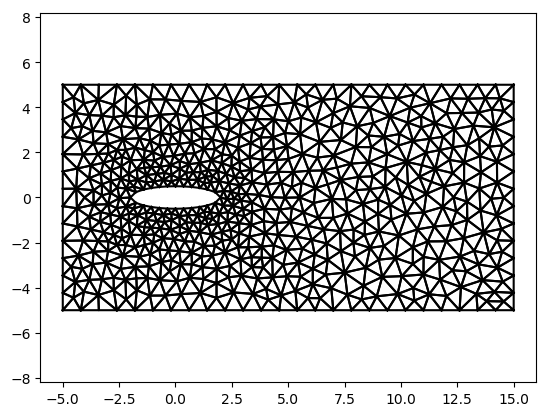

In [4]:
include("gmsh_mesh.jl")

gmsh = gmsh_mesh("domain.msh");

plot_mesh(gmsh);
axis("equal");

In [5]:
function ddt{T}(U::Field{T}, Uold::Field{T}, Δt::Float64)
    A = speye(length(U.values),length(U.values)) / Δt
    b = - Uold.values / Δt
    return Equation{T}(A, U.values, b)
end     

ddt (generic function with 2 methods)

In [27]:
function PISO(U, p, ν, Δt, steps)
    local ϕ = interpolate_U_to_faces(U)
    Uold = deepcopy(U)
    
    for n=1:steps
        Uold ← U.values

        UEqn = ddt(U, Uold, Δt) + div(ϕ,U) - Δ(ν,U)
        
        # Prediktor
        solve!(UEqn + ∇(p))

        # Prvni korektor
        ra = 1 ./ Ac(UEqn)        
        Ubar = VectorField(ra .* H(UEqn), U.mesh, U.boundaries);
        pEqn = Δ(ra, p) - ∇(Ubar);

        solve!(pEqn)
        calculate_ϕ!(ϕ, Ubar, p, ra)
        
        U ← Ubar - ra .* ∇(p)

        # Druhy korektor
        UEqn = ddt(U, Uold, Δt) + div(ϕ,U) - Δ(ν,U)
        ra = 1 ./ Ac(UEqn)        
        Ubar = VectorField(ra .* H(UEqn), U.mesh, U.boundaries);
        pEqn = Δ(ra, p) - ∇(Ubar);

        solve!(pEqn)
        calculate_ϕ!(ϕ, Ubar, p, ra)
        
        U ← Ubar - ra .* ∇(p)
    
    end

    return U,p
end

PISO (generic function with 1 method)

In [28]:
cmap = ColorMap("rainbow");

In [29]:
U = VectorField(gmsh)
set_dirichlet_patch!(U, "INLET", Vec2d(1,0));
set_dirichlet_patch!(U, "TOP", Vec2d(0,0));
set_dirichlet_patch!(U, "BOTTOM", Vec2d(0,0));
set_dirichlet_patch!(U, "PROFILE", Vec2d(0,0));
set_neumann_patch!(U, "OUTLET", Vec2d(0,0));
U.values = [Vec2d(0,0) for c in gmsh.cells]

p = ScalarField(gmsh);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(p, name, 0.0)
end
set_dirichlet_patch!(p, "OUTLET", 0.0);

ν = 1.e-3

0.001

In [30]:
U, p = PISO(U, p, ν, 1.e-3, 100);

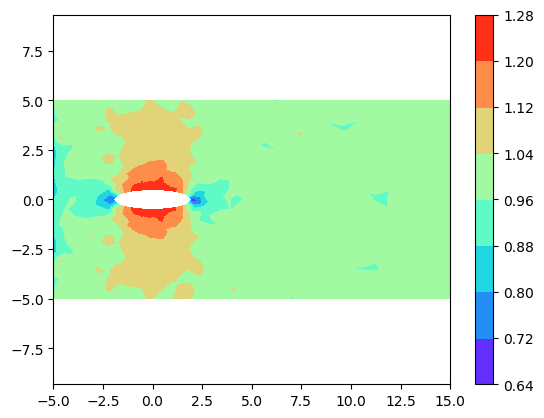

In [31]:
plot_contourf(U; cmap=cmap); colorbar();
#plot_arrows(U);
axis("equal");

In [32]:
gmf = gmsh_mesh("domain_bl.msh");

In [36]:
Uf = VectorField(gmf)
set_dirichlet_patch!(Uf, "INLET", Vec2d(1,0));
set_dirichlet_patch!(Uf, "TOP", Vec2d(0,0));
set_dirichlet_patch!(Uf, "BOTTOM", Vec2d(0,0));
set_dirichlet_patch!(Uf, "PROFILE", Vec2d(0,0));
set_neumann_patch!(Uf, "OUTLET", Vec2d(0,0));
Uf.values = [Vec2d(0.1,0.1) for c in gmf.cells]

pf = ScalarField(gmf);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(pf, name, 0.0)
end
set_dirichlet_patch!(pf, "OUTLET", 0.0);

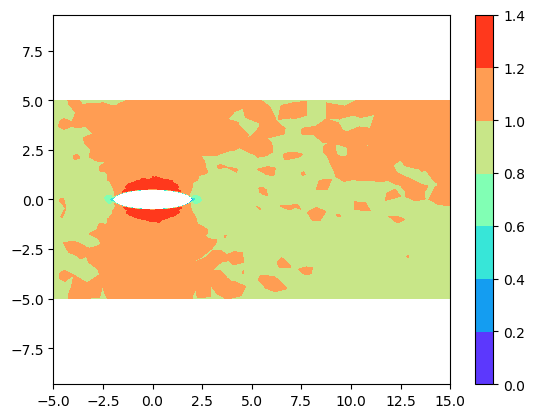

In [37]:
Uf, pf = PISO(Uf, pf, ν, 1.e-2, 10);
plot_contourf(Uf; cmap=cmap); colorbar();
axis("equal");

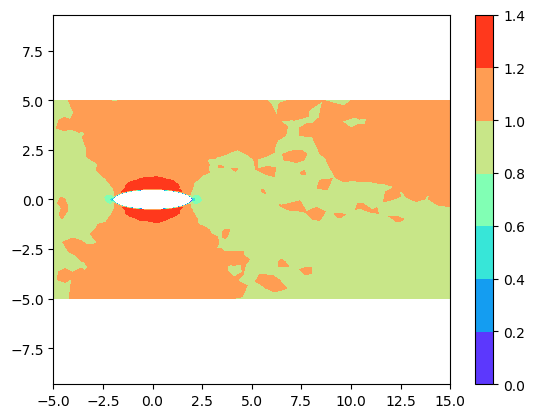

In [38]:
Uf, pf = PISO(Uf, pf, ν, 1.e-2, 10);
plot_contourf(Uf; cmap=cmap); colorbar();
axis("equal");

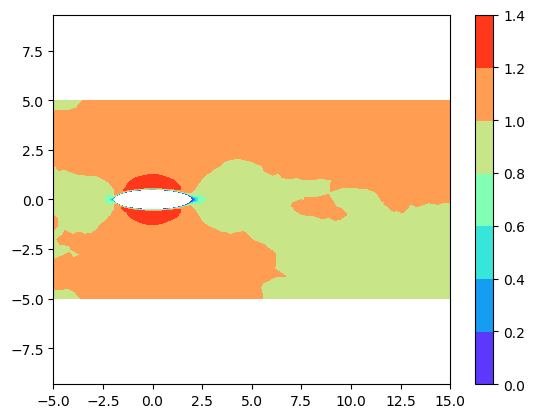

In [39]:
Uf, pf = PISO(Uf, pf, ν, 1.e-2, 100);
plot_contourf(Uf; cmap=cmap); colorbar();
axis("equal");

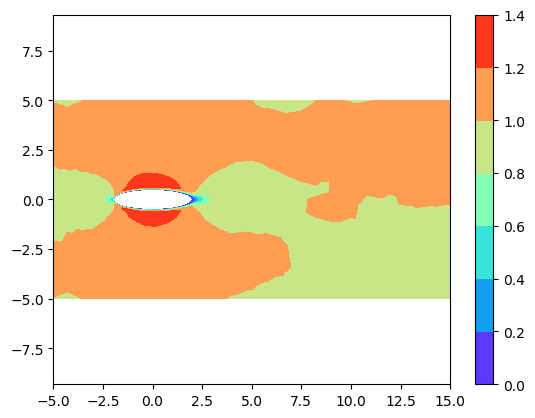

In [40]:
Uf, pf = PISO(Uf, pf, ν, 1.e-2, 100);
plot_contourf(Uf; cmap=cmap); colorbar();
axis("equal");